# Information Theoretic Quantum Phase Estimation for Hydrogen

This is needed to debug `CUDA-Q` calls:

In [ ]:
# import os

# os.environ["CUDAQ_LOG_LEVEL"] = "info"
# os.environ["CUDAQ_LOG_LEVEL"] = "trace"

!python -m pip install pytket==1.40.0

## Using `pytket` to generate a set of circuits: this will be our baseline

We rely on the `algorithm` module in the `sca25_demo_qpe` repository:

In [1]:
import numpy as np
from algorithm import generate_ks

In [4]:
# Prepare the samples of (k, beta).
k_max = 16
n_samples = 50  # this will set how many circuits we need to run for the QPE
error_rate = 0.0  # use 0 for noiseless simulations
# k_max = 50
# n_samples = 250
# error_rate = 0.01


def error_rate_func(k: int) -> float:
    q = 1 - (1 - error_rate) ** k
    return q


k_list = generate_ks(k_max, n_samples, error_rate=error_rate_func)
beta_list = (1 - 2 * np.random.random(size=n_samples)).tolist()


## Hamiltonian for the tapered 1-qubit Hydrogen molecule: the controlled unitary is directly implemented

In [6]:
# 1-qubit controlled Hamiltonian trotterization coefficients
CZ = 0.7960489286466914
CX = -0.1809233927385484
CI = -0.3209561440881913
DELTAT = 0.1
# Exact energy
FCI_ENERGY = -1.13730605

In [7]:
from pytket import Circuit
from pytket.pauli import Pauli
from pytket.circuit import PauliExpBox

In [8]:
# ctrl-Unitary: the unitary is U^k where U is e^{-idtH}
def get_ctrlu(k: int) -> Circuit:
    circ = Circuit(2)
    for ii in range(k):
        circ.add_pauliexpbox(
            PauliExpBox([Pauli.Z], CZ*DELTAT),
            [circ.qubits[1]],
        )
        circ.add_pauliexpbox(
            PauliExpBox([Pauli.Z, Pauli.Z], -CZ*DELTAT),
            circ.qubits,
        )
        circ.add_pauliexpbox(
            PauliExpBox([Pauli.X], CX*DELTAT),
            [circ.qubits[1]],
        )
        circ.add_pauliexpbox(
            PauliExpBox([Pauli.Z, Pauli.X], -CX*DELTAT),
            circ.qubits,
        )
        if (ii + 1) >= k:
            break
            
    circ.add_pauliexpbox(
        PauliExpBox([Pauli.Z], -CI*k*DELTAT),
        [circ.qubits[0]],
    )
    return circ

In [11]:
from pytket.circuit.display import render_circuit_jupyter as draw 

circ = get_ctrlu(2)
draw(circ)

In [12]:
print(circ.get_statevector().round(3))

[ 0.995-0.101j -0.   -0.j     0.   +0.j     0.   +0.j   ]


In [13]:
from pytket.passes import DecomposeBoxes

DecomposeBoxes().apply(circ)
draw(circ)

## Convert the controlled-unitary circuit to CUDA-Q using `exp_pauli` objects

This is a literal translation

In [17]:
import cudaq
import numpy as np
from math import pi

`PauliExpBox` is converted to `exp_pauli`

In [18]:
# take care of the angle rescaling between `exp_pauli` and `PauliExpBox`
coefficients = np.array(
    [
        -pi / 2 * c
        for c in [CZ * DELTAT, -CZ * DELTAT, CX * DELTAT, -CX * DELTAT, -CI * DELTAT]
    ],
    dtype=np.float64,
)

# passing float coefficients is the only way to make it work right now
@cudaq.kernel
def ctrlu(k: int, coeffs: list[float]):
    # 2-qubit register
    q = cudaq.qvector(2)
    # Loop over k
    for i in range(k):
        exp_pauli(coeffs[0], q, "IZ")  # this is the pauli exponential e^{i c I0Z1}
        exp_pauli(coeffs[1], q, "ZZ")  # this is the pauli exponential e^{i c Z0Z1}
        exp_pauli(coeffs[2], q, "IX")  # this is the pauli exponential e^{i c I0X1}
        exp_pauli(coeffs[3], q, "ZX")  # this is the pauli exponential e^{i c Z0X1}
    # add final phase
    exp_pauli(coeffs[4]*k, q, "ZI")  # this is the pauli exponential e^{i c Z0I1}

Let's get the statevector on CPU. It matches the amplitude we get from `pytket` on the 00 state

In [24]:
# Define the simulation target.
cudaq.set_target("qpp-cpu")

# Compute the statevector of the kernel
result = cudaq.get_state(ctrlu, 2, coefficients)

print(np.array(result).round(3))

[ 0.995-0.101j  0.   +0.j    -0.   -0.j     0.   +0.j   ]


We can print the `cudaq` decomposed circuit. We note that `cudaq` implements the pauli exponentials by inverting the control and the target qubits:

In [26]:
print(cudaq.draw(ctrlu, 2, coefficients))

                                                                           »
q0 : ────────────────●───────────────────●─────────────────────────────────»
     ╭────────────╮╭─┴─╮╭─────────────╮╭─┴─╮╭───╮╭──────────────╮╭───╮╭───╮»
q1 : ┤ rz(0.2501) ├┤ x ├┤ rz(-0.2501) ├┤ x ├┤ h ├┤ rz(-0.05684) ├┤ h ├┤ h ├»
     ╰────────────╯╰───╯╰─────────────╯╰───╯╰───╯╰──────────────╯╰───╯╰───╯»

################################################################################

                                                                          »
──●───────────────────●───────────────────────●───────────────────●───────»
╭─┴─╮╭─────────────╮╭─┴─╮╭───╮╭────────────╮╭─┴─╮╭─────────────╮╭─┴─╮╭───╮»
┤ x ├┤ rz(0.05684) ├┤ x ├┤ h ├┤ rz(0.2501) ├┤ x ├┤ rz(-0.2501) ├┤ x ├┤ h ├»
╰───╯╰─────────────╯╰───╯╰───╯╰────────────╯╰───╯╰─────────────╯╰───╯╰───╯»

################################################################################

                                                   ╭────────────╮
───

Try and run on Quantinuum after setting up credentials in `~/.quantinuum_config`

In [29]:
# By default, we will submit to the Quantinuum syntax checker. 
# With emulate=True it will only test the compilation without querying the API
cudaq.set_target("quantinuum", emulate=True)


# Create the kernel we'd like to execute on Quantinuum.
# remember to add measurements or it will fail with emulate=False
@cudaq.kernel
def kernel():
    qvector = cudaq.qvector(2)
    h(qvector[0])
    x.ctrl(qvector[0], qvector[1])
    mz(qvector[0])
    mz(qvector[1])

In [30]:
counts = cudaq.sample(kernel, shots_count=1)
counts.dump()

{ 00:1 }


Test our `ctrlu` kernel without measurements on `quantinuum` with `emulate=True`

In [31]:
counts = cudaq.sample(ctrlu, 1, coefficients, shots_count=1)
counts.dump()

{ 00:1 }


## Get the full QPE circuit in `pytket`

In [32]:
from algorithm import get_qpe_func

In [33]:
# Prepare the Hartree-Fock state
state = Circuit(1).X(0)

qpe_func = get_qpe_func(
    state,
    get_ctrlu,
    n_rounds=1,
)

circ = qpe_func(k=2, beta=0.25)

In [34]:
draw(circ)

Get the statevector to check the results against `cudaq`. Remove the measurements at the end of the circuit to be able to get the statevector directly from `pytket`

In [37]:
# remove measurements
def _remove_measurements(circ: Circuit) -> Circuit:
    """Return the circuit with measurements removed"""
    circ_dict = circ.to_dict()
    new_cmds = [x for x in circ_dict["commands"] if x["op"]["type"] != "Measure"]
    circ_dict["commands"] = new_cmds
    return Circuit.from_dict(circ_dict)

circ_no_meas = _remove_measurements(circ)

In [38]:
circ_no_meas.get_statevector().round(3)

array([-0.037+0.04j ,  0.711+0.18j ,  0.037-0.04j ,  0.17 -0.654j])

## Translate the full QPE circuit to CUDA-Q by combining different kernels

We have the same `ctrlu` kernel as before. Now we make it act on a register `q` that we pass as input:

In [42]:
@cudaq.kernel
def ctrlU(qubits: cudaq.qview, k: int, coeffs: list[float]):
    # Loop over k
    for i in range(k):
        exp_pauli(coeffs[0], qubits, "IZ")
        exp_pauli(coeffs[1], qubits, "ZZ")
        exp_pauli(coeffs[2], qubits, "IX")
        exp_pauli(coeffs[3], qubits, "ZX")
    # add final phase
    exp_pauli(coeffs[4]*k, qubits, "ZI")

Then we have a state preparation circuit that we make it act on the single qubit of the Hydrogen molecule system. It prepares a Hartree-Fock initial state:

In [39]:
@cudaq.kernel
def statePrep(qubit: cudaq.qubit):
    x(qubit)

This is the full QPE circuit for `k` and `beta` and using the `coefficients` that define the Hydrogen Hamiltonian

In [56]:
@cudaq.kernel
def qpe_kernel(
    k: int,
    beta: float,
    coefficients: list[float],
):
    q = cudaq.qvector(2)  # we always only use 2 qubits
    ancilla = q[0]  # we use this qubit to read the results
    register = q[1]  # this is the system qubit
    # we add the gates one after the other. a kernel will add all the gates it has inside
    h(ancilla)
    statePrep(register)
    ctrlU(q, k, coefficients)
    rz(math.pi * beta, ancilla)  # account for different angle conventions between pytket and cudaq
    h(ancilla)  # inverse QFT on a single qubit
    # we do not measure here so we can check the full statevector

In [57]:
cudaq.set_target("qpp-cpu")

result = cudaq.get_state(qpe_kernel, 2, 0.25, coefficients)
print(np.array(result).round(3))

[-0.037+0.04j   0.037-0.04j   0.711+0.18j   0.17 -0.654j]


In [58]:
result.amplitude('01')

(0.7108268099435376+0.1800402809974428j)

The statevector generated by the `get_state` command follows Big-endian convention for associating numbers with their binary representations, which places the least significant bit on the left.  That is, for the example of a 2-bit system, we have the following translation between integers and bits:
$$\begin{matrix} \text{Integer} & \text{Binary representation}\\
& \text{least significant bit on left}\\
0 =\textcolor{red}{0}*2^0+\textcolor{blue}{0}*2^1 & \textcolor{red}{0}\textcolor{blue}{0} \\
1 = \textcolor{red}{1}*2^0 + \textcolor{blue}{0} *2^1 & \textcolor{red}{1}\textcolor{blue}{0}\\
2 = \textcolor{red}{0}*2^0 + \textcolor{blue}{1}*2^1 & \textcolor{red}{0}\textcolor{blue}{1} \\
3 = \textcolor{red}{1}*2^0 + \textcolor{blue}{1}*2^1 & \textcolor{red}{1}\textcolor{blue}{1} \end{matrix}
$$

In [74]:
# from pytket k=1: 
# state | amplitude
# 00    | -0.018 + 0.022j
# 01    | 0.836 + 0.105j
# 10    | 0.018 - 0.022j
# 11    | 0.068 - 0.533j
# from pytket k=2:
# state | amplitude
# 00    | -0.037 + 0.04j
# 01    | 0.711 + 0.18j
# 10    | 0.037 - 0.04j
# 11    | 0.17 - 0.654j

In [45]:
print(cudaq.draw(qpe_kernel, 2, 0.25, coefficients))

     ╭───╮                                                                 »
q0 : ┤ h ├────────────────●───────────────────●────────────────────────────»
     ├───┤╭────────────╮╭─┴─╮╭─────────────╮╭─┴─╮╭───╮╭──────────────╮╭───╮»
q1 : ┤ x ├┤ rz(0.2501) ├┤ x ├┤ rz(-0.2501) ├┤ x ├┤ h ├┤ rz(-0.05684) ├┤ h ├»
     ╰───╯╰────────────╯╰───╯╰─────────────╯╰───╯╰───╯╰──────────────╯╰───╯»

################################################################################

                                                                          »
───────●───────────────────●───────────────────────●───────────────────●──»
╭───╮╭─┴─╮╭─────────────╮╭─┴─╮╭───╮╭────────────╮╭─┴─╮╭─────────────╮╭─┴─╮»
┤ h ├┤ x ├┤ rz(0.05684) ├┤ x ├┤ h ├┤ rz(0.2501) ├┤ x ├┤ rz(-0.2501) ├┤ x ├»
╰───╯╰───╯╰─────────────╯╰───╯╰───╯╰────────────╯╰───╯╰─────────────╯╰───╯»

################################################################################

                                                        ╭────────────

## Run QPE

In `CUDA-Q` we can run the kernels that we generate using the `k_list` and `beta_list` values. Since we want to get samples from them, we could do it in parallel on multi-CPU or multi-GPU with the [sample_async](https://nvidia.github.io/cuda-quantum/latest/api/languages/python_api.html#cudaq.sample_async) function

In [46]:
# add measurement
@cudaq.kernel
def qpe_kernel(
    k: int,
    beta: float,
    coefficients: list[float],
):
    q = cudaq.qvector(2)  # we always only use 2 qubits
    ancilla = q[0]
    register = q[1]
    h(ancilla)
    statePrep(register)
    ctrlU(q, k, coefficients)
    rz(math.pi * beta, ancilla)
    h(ancilla)
    # we add the measurement to be able to sample
    mz(ancilla)

In [47]:
counts = cudaq.sample(qpe_kernel, 1, -0.25, coefficients, shots_count=1)

We only measure one ancilla qubit, so the counts will look like this:

In [48]:
counts.dump()

{ 0:1 }


In [49]:
# CPU
cudaq.set_target('qpp-cpu')
# Quantinuum
# cudaq.set_target('quantinuum', emulate=True)

# Execute the QPE circuits.
results = []
for k,b in zip(k_list,beta_list):
    results.append(cudaq.sample(qpe_kernel, k, b, coefficients, shots_count=1))

We write a helper function to translate the CUDA-Q `SampleResult` into the pytket `BackendResult`

In [50]:
from pytket import Bit 
from pytket.backends.backendresult import BackendResult
from pytket.utils.outcomearray import OutcomeArray
from typing import Counter


def get_decoded_result(result: cudaq.SampleResult) -> BackendResult:
    logical_counts = Counter()
    for logical_readout, counts in result.items():
        logical_counts[OutcomeArray.from_readouts([[logical_readout]])] += counts
    logical_result = BackendResult(
        counts=logical_counts,
        c_bits=[Bit(0)],
    )
    return logical_result

In [51]:
# Interpret the cuda-q results as pytket BackendResults
logical_results = [get_decoded_result(r) for r in results]

In [52]:
logical_results[0]

BackendResult(q_bits={},c_bits={c[0]: 0},counts=Counter({OutcomeArray([[0]], dtype=uint8): 1}),shots=None,state=None,unitary=None,density_matrix=None)

## Post-process the results using our own pytket pipeline:

In [53]:
from algorithm import get_mu_and_sigma, bayesian_update


# Prepare the uniform prior distribution.
n_grid_points = 2**10
phi = np.linspace(-1, 1, n_grid_points + 1)[:-1]
prior = np.ones_like(phi)

posterior = bayesian_update(
    phi,
    prior,
    k_list,
    beta_list,
    logical_results,
    error_rate=error_rate_func,
)

In [54]:
mu, sigma = get_mu_and_sigma(posterior, phi=phi)
mu_energy = -mu / DELTAT
sigma_energy = sigma / DELTAT
print(f"Energy estimate = {mu_energy:11.5f} Ha")
print(f"Energy sigma    = {sigma_energy:11.5f} Ha")
print(f"FCI energy      = {FCI_ENERGY:11.5f} Ha")

Energy estimate =    -1.11294 Ha
Energy sigma    =     0.04864 Ha
FCI energy      =    -1.13731 Ha


### Plot probability distribution

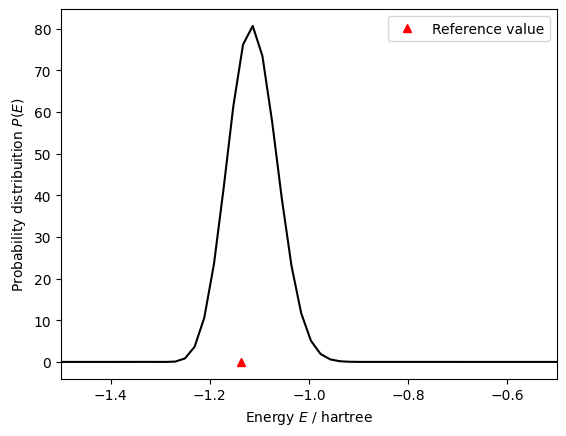

In [55]:
import matplotlib.pyplot as plt

x_energy = -phi / DELTAT
plt.plot(x_energy, posterior, "k-")
plt.plot(FCI_ENERGY, 0, "r^", label="Reference value")
plt.xlim(-1.5,-0.5)
plt.xlabel(r"Energy $E$ / hartree")
plt.ylabel(r"Probability distribuition $P(E)$")
plt.legend()